*best viewed in [nbviewer](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/yqtl_association_with_advb.ipynb)*

<center><h1>Yiqṭol and Its Association with Prototypical Adverbs</h1></center>
<center><h3 style="font-weight:normal">Cody Kingham</h3></center>
<center><h2><a href="../../docs/sponsors.md"><img height=20% width=20% src="../../docs/images/CambridgeU_BW.png"></a></h2></center>

In [1]:
! echo "last updated:"; date

last updated:
Fri 31 Jan 2020 17:34:47 GMT


## Why does yiqṭol prefer particles?

In [a preliminary analysis](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/archive/2019-10-31/analysis/exploratory/construction_clusters.ipynb), we found evidence that the yiqṭol verb tends to be attracted to time words which can be considered "prototypical adverbs". These are words which are infrequently combined with constructions that indicate number, definiteness, or possession (see Croft, "A Conceptual Frameowork for Grammatical Categories," 1990). These prototypical adverbs include words such as אז ,נצח ,עולם ,מתי ,עתה. In [the study on parts of speech](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/time_distribution_and_pos.ipynb), we found an empirical basis for separating these words from their noun counterparts on the grounds of their collocability with nominalizing constructions.

The preliminary analysis cited above found a statistical association between yiqṭol and prototypical adverbs. **In this notebook, we seek to confirm that yiqṭol indeed has a preference for these adverb terms, and we ask why?**

### Why does it matter?

One of the surprising things about this pattern, as this notebook will demonstrate, is that not all of the yiqṭol adverbs seem to fit the same semantic mold. For instance, the semantics of אז, which refers to a point in time, is different from עולם, which refers to a unknown duration. And yet, these words share two major qualities: they are both adverb-like, and they both seem to prefer the yiqṭol verb (as we will seek to confirm). This is surprising because we might assume that yiqṭol's preference is primarily semantic in nature: durational terms such as עולם and נצח would fit the widely-agreed, unbounded meaning of the verbal form. But אז suggests another possibility: that yiqṭol's preference is not wholly predictable from its semantics, but possibly due to a convention of use. Or, in other words, it is simply an idiosyncratic quality of yiqṭol to easily combine with adverbs. This would not mean such behavior has *no* semantic motivation. Perhaps the association of yiqṭol with durational adverbs opened the door for an association with adverbs in general. **These questions are purely hypothetical. And in this notebook we will seek to find empirical data that can help (in)validate these hypotheses and suggest further directions for analysis.**

<hr>

<center><h2>Python</h2></center>

## Import Modules and Data

In [2]:
# standard packages
from pathlib import Path
import collections
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# custom package in /tools
from paths import main_table, figs
from tf_tools.load import load_tf
from tf_tools.tokenizers import tokenize_surface
from cx_analysis.load import cxs
from cx_analysis.search import SearchCX
from stats.significance import contingency_table, apply_fishers
from stats.pca import apply_pca

TF, API, A = load_tf(silent='deep')
A.displaySetup(condenseType='phrase')
F, E, T, L = A.api.F, A.api.E, A.api.T, A.api.L
se = SearchCX(A)
phrase2cxs = cxs['phrase2cxs']
class2cx = cxs['class2cx']
time_cxs = list(phrase2cxs.values())

# configure data output
name = 'yqtl_association_with_advb'
figures = figs.joinpath(name)
if not figures.exists():
    figures.mkdir(parents=True)
def fg_path(fg_name):
    return figures.joinpath(fg_name)

In [3]:
# set up project dataset
times_full = pd.read_csv(main_table, sep='\t')
times_full.set_index(['node'], inplace=True)
times = times_full[~times_full.classi.str.contains('component')]

# Adverb Collocations with Yiqṭol

We pick up the thread where we left off in [the notebook on parts of speech](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/time_distribution_and_pos.ipynb). There we used Principal Component Analysis (PCA) to isolate prototypical adverbs from nouns. We duplicate that same method here and begin to look at the collocational tendencies of these items compared against verbs. 

In [4]:
# compile collocation table of time heads with nominalizing constructions
time_cols = pd.pivot_table(
    times, 
    index=['time'], 
    values=['time_pl', 'quantified', 'definite', 
            'demonstrative', 'ordinal', 'time_sffx',
            'bare', 'genitive'],
    aggfunc=np.sum
)

# sort on size
time_cols = time_cols.loc[time_cols.sum(1).sort_values(ascending=False).index]

# drop observations with < 5 total sample size
time_cols = time_cols[time_cols.sum(1) > 4]

# calculate ratio
time_col_ratio = time_cols.div(time_cols.sum(1), axis=0)

# apply PCA to dataset
time_pca, time_loadings = apply_pca(time_col_ratio, 0, 1, scree=False)

The results of the PCA analysis and its implications are explored and explained further in the notebook linked to above. The resulting PCA space is illustrated below, as calculated in that notebook.

<img src="../figures/time_distribution_and_pos/time_head_clusters.png" height=40%, width=40%>

The items to the right of the plot are the adverb group. We can select them by pulling all words with an x-axis value (principal component 1 or PC1) which is > 0. We can generalize and say that in this model terms which have a higher x-axis value are "more adverbial." Although, this categorization remains a working hypothesis. Those forms are shown below in descending order. Note that all words down to עתה have the same value of `0.59`.

In [5]:
advbs = time_pca[time_pca['PC1'] > 0].iloc[:, :2]
advbs = advbs.sort_values(by='PC1', ascending=False) # sort by distance from origin

advbs

,PC1,PC2
time,,
יומם,0.594394,0.015739
מתי,0.594394,0.015739
טרם,0.594394,0.015739
מהר,0.594394,0.015739
אן,0.594394,0.015739
מהרה,0.594394,0.015739
עד,0.594394,0.015739
שׁני,0.594394,0.015739
פתאם,0.594394,0.015739


By contrast, we can also select a list of nouns, which lie on the opposite end of the spectrum. They are similarly sorted from more noun-like to least. 

In [6]:
nouns = time_pca[time_pca['PC1'] < 0].iloc[:, :2]
nouns = nouns.sort_values(by='PC1')

nouns

,PC1,PC2
time,,
ערב,-0.580424,0.625062
שׁבת,-0.570566,0.566568
צהרים,-0.543954,0.177061
מועד,-0.520614,0.224347
ראשׁון,-0.515487,0.673805
שׁבוע,-0.507066,-0.182967
פעם,-0.503780,-0.183474
תחלה,-0.495743,0.242419
רגל,-0.495375,-0.422494


## Compare Verb Tense Collocational Tendencies

We will now make a count of these two categories' collocational tendencies with certain verb tenses. We depend on the [BHSA's](https://github.com/ETCBC/bhsa) encoding of the verbs, which distinguish the following possible categories:

| name | tag |
| ---- | --- |
| qaṭal | qtl |
| yiqṭol| yqtl |
| wayyiqṭol | wyqtl |
| imperative | impv |
| participle | ptcp |
| infinitive | inf |

Note that the tense names/tags have been adapted from BHSA terms like "imperfect" to fit the more theory-neutral terminology. A further category has been added by this project's code, that of the `weqetal` (see the production code [here](../../data/bhsa/tenses.py)):

| name | tag | 
| ---  | --- |
| weqeṭal | wqtl |

For this analysis, we will focus on `qtl`, `yqtl`, `wyqtl`, `wqtl`, and `ptcp`, leaving aside the imperative and infinitives for now. We do not yet distinguish verb tenses on the basis of positionality or length (e.g. long versus short yiqṭol). 

### Calculate and compare tense tendencies with adverbs / nouns

First we build a table, `tense_cols` which contains tense collocation counts.

In [7]:
tense_cols = times.pivot_table(index=['time'], columns=['tense'], aggfunc='size').fillna(0)
tense_cols = tense_cols[['qtl', 'wqtl', 'wyqtl', 'yqtl', 'ptcp',]]
tense_cols = tense_cols.loc[tense_cols.sum(1).sort_values(ascending=False).index]
tense_ratios = tense_cols.divide(tense_cols.sum(1), axis=0)

In [8]:
tense_cols.head()

tense,qtl,wqtl,wyqtl,yqtl,ptcp
time,,,,,
יום,331.0,96.0,257.0,329.0,89.0
עוד,42.0,8.0,48.0,198.0,24.0
שׁנה,99.0,11.0,67.0,36.0,3.0
עולם,23.0,19.0,6.0,77.0,9.0
עת,29.0,6.0,31.0,42.0,12.0


In [9]:
tense_ratios.head()

tense,qtl,wqtl,wyqtl,yqtl,ptcp
time,,,,,
יום,0.300363,0.087114,0.233212,0.298548,0.080762
עוד,0.131250,0.025000,0.150000,0.618750,0.075000
שׁנה,0.458333,0.050926,0.310185,0.166667,0.013889
עולם,0.171642,0.141791,0.044776,0.574627,0.067164
עת,0.241667,0.050000,0.258333,0.350000,0.100000


Above you see the top 5 rows of the collocation table, as sorted by total observations. The rows contain all words, both adverbs and nouns, and the columns contain the tense tags. We will now select from this dataset the words we've identified as adverbs. 

### Select tenses collocated with "adverbs"

The selection happens below. We can see there a tally of raw adverb / tense collocation counts.

In [10]:
advb_tenses = tense_cols.loc[advbs.index]
advb_tenses = advb_tenses.loc[advb_tenses.sum(1).sort_values(ascending=False).index] # sort by N-observations

advb_tenses

tense,qtl,wqtl,wyqtl,yqtl,ptcp
time,,,,,
עוד,42.0,8.0,48.0,198.0,24.0
עולם,23.0,19.0,6.0,77.0,9.0
אז,43.0,0.0,1.0,72.0,3.0
עתה,45.0,0.0,0.0,44.0,2.0
כן,11.0,0.0,21.0,18.0,0.0
תמיד,2.0,6.0,0.0,18.0,6.0
מחר,1.0,1.0,0.0,20.0,4.0
נצח,4.0,0.0,0.0,20.0,1.0
מחרת,0.0,0.0,21.0,2.0,0.0


Below we have a look at the description of the dataset for tenses:

In [11]:
advb_tenses.describe()

tense,qtl,wqtl,wyqtl,yqtl,ptcp
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,9.950000,2.150000,5.800000,27.500000,2.900000
std,15.271146,4.522168,11.954299,45.555634,5.485867
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,6.000000,0.000000
50%,3.000000,0.000000,0.000000,11.500000,1.000000
75%,6.500000,2.000000,4.500000,20.000000,3.000000
max,45.000000,19.000000,48.000000,198.000000,24.000000


`count` refers to number of non-zero observations. `25%` etc. refer to the percentile.

We now convert the raw count data into a ratio normalized to the word. 

#### Linear regression analysis: PC1 versus Yiqṭol

I'm curious to test whether distance along PC1 space correlates with frequency of use with the yiqṭol verb. We will do a regression analysis to find out.

In [12]:
pc1_and_yqtl = pd.concat([advb_tenses['yqtl'], advbs['PC1']], axis=1, sort=True)

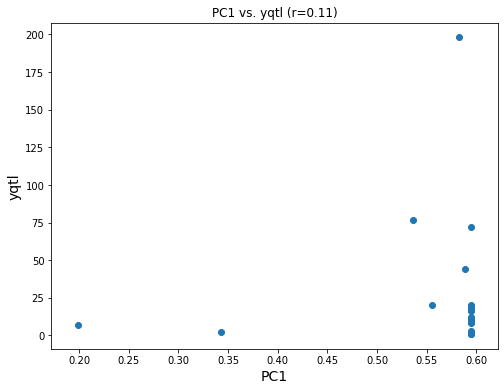

In [13]:
x, y = pc1_and_yqtl['PC1'], pc1_and_yqtl['yqtl']
slope, intercept, r, p, std_err = linregress(x,y)
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('PC1', size=14)
ax.set_ylabel('yqtl', size=14)
ax.scatter(x=x, y=y)
#ax.plot(x, intercept + slope*x, 'r', label='fitted line')
ax.set_title(f'PC1 vs. yqtl (r={round(r, 2)})')
plt.show()

The regression analysis does not show any strong correlation between the PC1 values and use with yiqṭol (`r=0.11`), as we can confirm from the graph itself.

#### Association with given times

In [14]:
advb_time_assoc = apply_fishers(advb_tenses)

advb_time_assoc

,qtl,wqtl,wyqtl,yqtl,ptcp
עוד,-4.341678,-1.339933,1.334313,1.490292,0.709926
עולם,-0.447469,6.188177,-2.617443,0.033716,0.157806
אז,4.539968,-2.164134,-5.529864,0.366625,-1.001978
עתה,10.107751,-1.556913,-5.014376,-1.021997,-0.797368
כן,0.066847,-0.790099,7.529807,-2.520843,-1.174080
תמיד,-1.357342,2.683485,-1.598313,0.000000,2.016684
מחר,-1.566343,0.000000,-1.205048,1.356749,1.187621
נצח,-0.095814,-0.205831,-1.208736,1.641021,0.000000
מחרת,-2.126285,-0.207896,17.757475,-5.850403,-0.406927
פתאם,0.097427,0.000000,0.461411,-0.171334,0.000000


#### Look at strong statistical (dis)associations with yiqtol

In [15]:
pd.DataFrame(advb_time_assoc['yqtl'][advb_time_assoc['yqtl'] > 1.3])

,yqtl
עוד,1.490292
מחר,1.356749
נצח,1.641021
מתי,1.397496


In [16]:
pd.DataFrame(advb_time_assoc['yqtl'][advb_time_assoc['yqtl'] < -1.3])

,yqtl
כן,-2.520843
מחרת,-5.850403
שׁני,-3.694525
מהר,-1.329739


#### Ratio Across All "adverbs"

In [17]:
advb_tenses.sum() / advb_tenses.sum().sum()

tense
qtl      0.206004
wqtl     0.044513
wyqtl    0.120083
yqtl     0.569358
ptcp     0.060041
dtype: float64

Here ^ we see that nearly 60% of these adverb uses are collocations with yiqṭol. How does that compare with the rest?

#### Observe average across all adverbs

In [18]:
advb_tense_avg = advb_tenses.div(advb_tenses.sum(1), axis=0)

advb_tense_avg

tense,qtl,wqtl,wyqtl,yqtl,ptcp
time,,,,,
עוד,0.131250,0.025000,0.150000,0.618750,0.075000
עולם,0.171642,0.141791,0.044776,0.574627,0.067164
אז,0.361345,0.000000,0.008403,0.605042,0.025210
עתה,0.494505,0.000000,0.000000,0.483516,0.021978
כן,0.220000,0.000000,0.420000,0.360000,0.000000
תמיד,0.062500,0.187500,0.000000,0.562500,0.187500
מחר,0.038462,0.038462,0.000000,0.769231,0.153846
נצח,0.160000,0.000000,0.000000,0.800000,0.040000
מחרת,0.000000,0.000000,0.913043,0.086957,0.000000


In [19]:
advb_tense_avg.mean()

tense
qtl      0.212578
wqtl     0.059157
wyqtl    0.135037
yqtl     0.527609
ptcp     0.065620
dtype: float64

#### adverbs with > 50% of yiqtol representation

In [20]:
pd.DataFrame(advb_tense_avg['yqtl'][advb_tense_avg['yqtl'] > 0.5] )

,yqtl
time,
עוד,0.618750
עולם,0.574627
אז,0.605042
תמיד,0.562500
מחר,0.769231
נצח,0.800000
פתאם,0.521739
מתי,0.800000
עד,0.785714


## Nouns?

In [21]:
# noun = head_components[head_components['PC1'] > 0].iloc[:, :2]

# noun

In [22]:
# noun_tenses = tense_cols.loc[noun.index]

# noun_tenses

In [23]:
# noun_tenses.sum() / noun_tenses.sum().sum()

### Both Compared

In [24]:
# both_tenses = pd.concat([advb_tenses.sum(), noun_tenses.sum()], axis=1)
# both_tenses.columns=['advb?', 'noun?']
# both_tenses = both_tenses.T
# both_tenses

In [25]:
# both_tenses.sum()

#### Ratio

In [26]:
# both_tenses_ratio = both_tenses.div(both_tenses.sum(1), axis=0)

# both_tenses_ratio

#### Fisher's

We can now apply a measure of association between the three groups. We can see that both dependent and independent adverbs are associated with yiqtol.

In [27]:
# apply_fishers(both_tenses)

## Collocation with Nominalizing Constructions

Rather than comparing uses of yiqṭol with a grouping of adverbs, a more direct and accurate measurement might be to test how often yiqṭol occurs alongside nominalizing constructions. A nominalizing construction is any form which modifies a head word and indicates definiteness, quantity, or posession. We assemble the datasets below along with the verb collocations.

In [62]:
sample = time_cols[time_cols.sum(1) > 10]
sample_tenses = tense_ratios.loc[sample.index]
sample_cols = time_col_ratio.loc[sample.index]

In [63]:
do_cxs = [
    'definite', 'demonstrative', 
    'quantified', 'time_pl', 'genitive',
    'bare',
]

nom_yiq_dataset = {}

for cx in do_cxs:
    cx_data = sample_cols[cx]
    tense_data = sample_tenses['yqtl']
    tense_and_cx = pd.concat([cx_data, tense_data], sort=False, axis=1).fillna(0)
    tense_and_cx = tense_and_cx[(tense_and_cx > 0).any(1)] # prune null counts
    nom_yiq_dataset[cx] = tense_and_cx

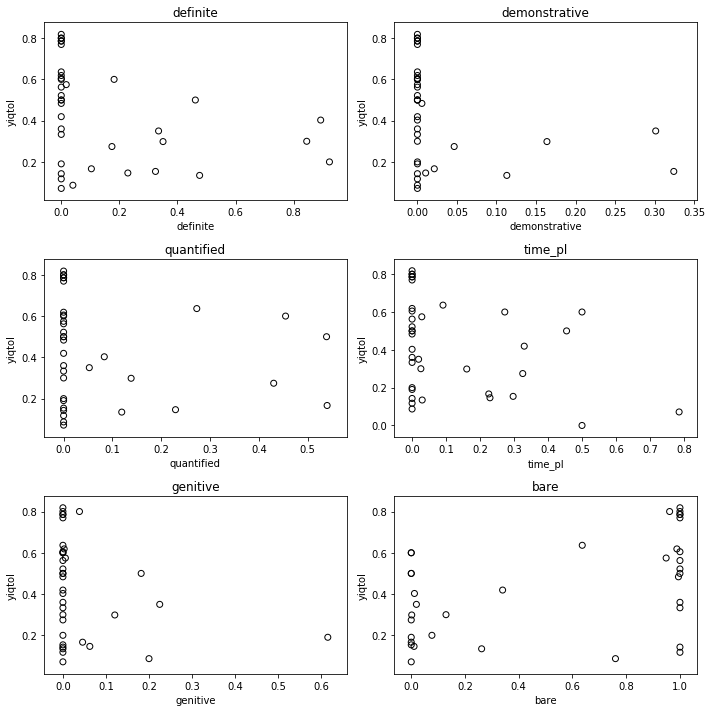

In [76]:
fig = plt.figure(figsize=(10,10))

for i, data in enumerate(nom_yiq_dataset.items()):
    
    # axes + linear regression analysis
    cx, df = data
    x, y =  df[cx], df['yqtl']
    #slope, intercept, r, p, std_err = linregress(x,y)
    
    # make plot
    ax = fig.add_subplot(3, 2, i+1)
    ax.scatter(x, y, color='', edgecolor='black')
    #ax.plot(x, intercept + slope*x, 'red')
    ax.set_ylabel('yiqtol')
    ax.set_xlabel(f'{cx}')
    ax.set_title(f'{cx}')# (r={round(r, 2)})')
fig.tight_layout()
plt.savefig(fg_path('yqtl_nominalizers_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

## Fisher's 

In [39]:
# tense_assoc = apply_fishers(tense_cols)
# tense_assoc.head(7)

In [38]:
# plt.figure(figsize=(10, 6))
# sns.heatmap(tense_assoc, center=0, robust=True)
# plt.yticks(rotation=0)
# plt.savefig(fg_path('tense_propcx_attractions.png'), dpi=300, bbox_inches='tight')
# plt.title('Tense and Propositional CX Attractions (Fisher\'s)')
# plt.show()

### ΔP Asymmetrical Tests

> "􏰁P is the probability of the outcome given the cue P(O|C) minus the probability of the outcome in the absence of the cue P(O|–C). When these are the same, when the outcome is just as likely when the cue is present as when it is not, there is no covariation between the two events and 􏰁P 1⁄4 0. 􏰁P approaches 1.0 as the presence of the cue increases the likelihood of the outcome and approaches –1.0 as the cue decreases the chance of the outcome—a negative association." -Ellis, "Language Acquisition," 2006, 11.

**NB: The following code needs to be checked over.**

#### Propositional CX as cue

In [34]:
# # unidirectional ΔP test
# con = contingency_table(tense_cols)
# dp_a, dp_b, dp_c, dp_d = [con[x] for x in ('a', 'b', 'c', 'd')]
# cx_cue = dp_a / (dp_a + dp_c) - dp_b / (dp_b + dp_d)

In [35]:
# cx_cue

#### Verb as Cue

In [36]:
# # unidirectional ΔP test
# con = contingency_table(tense_cols)
# dp_a, dp_b, dp_c, dp_d = [con[x] for x in ('a', 'b', 'c', 'd')]
# verb_cue = dp_a / (dp_a + dp_b) - dp_c / (dp_c + dp_d)

In [37]:
# verb_cue